In [ ]:
%matplotlib inline

Source: [https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html#exercise-computing-word-embeddings-continuous-bag-of-words](https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html#exercise-computing-word-embeddings-continuous-bag-of-words)

# Word Embeddings: Encoding Lexical Semantics

Word embeddings are dense vectors of real numbers, one per word in your
vocabulary. In NLP, it is almost always the case that your features are
words! But how should you represent a word in a computer? You could
store its ascii character representation, but that only tells you what
the word *is*, it doesn't say much about what it *means* (you might be
able to derive its part of speech from its affixes, or properties from
its capitalization, but not much). Even more, in what sense could you
combine these representations? We often want dense outputs from our
neural networks, where the inputs are $|V|$ dimensional, where
$V$ is our vocabulary, but often the outputs are only a few
dimensional (if we are only predicting a handful of labels, for
instance). How do we get from a massive dimensional space to a smaller
dimensional space?

How about instead of ascii representations, we use a one-hot encoding?
That is, we represent the word $w$ by

\begin{align}\overbrace{\left[ 0, 0, \dots, 1, \dots, 0, 0 \right]}^\text{|V| elements}\end{align}

where the 1 is in a location unique to $w$. Any other word will
have a 1 in some other location, and a 0 everywhere else.

There is an enormous drawback to this representation, besides just how
huge it is. It basically treats all words as independent entities with
no relation to each other. What we really want is some notion of
*similarity* between words. Why? Let's see an example.

Suppose we are building a language model. Suppose we have seen the
sentences

* The mathematician ran to the store.
* The physicist ran to the store.
* The mathematician solved the open problem.

in our training data. Now suppose we get a new sentence never before
seen in our training data:

* The physicist solved the open problem.

Our language model might do OK on this sentence, but wouldn't it be much
better if we could use the following two facts:

* We have seen  mathematician and physicist in the same role in a sentence. Somehow they
  have a semantic relation.
* We have seen mathematician in the same role  in this new unseen sentence
  as we are now seeing physicist.

and then infer that physicist is actually a good fit in the new unseen
sentence? This is what we mean by a notion of similarity: we mean
*semantic similarity*, not simply having similar orthographic
representations. It is a technique to combat the sparsity of linguistic
data, by connecting the dots between what we have seen and what we
haven't. This example of course relies on a fundamental linguistic
assumption: that words appearing in similar contexts are related to each
other semantically. This is called the `distributional
hypothesis <https://en.wikipedia.org/wiki/Distributional_semantics>`__.


# Getting Dense Word Embeddings

How can we solve this problem? That is, how could we actually encode
semantic similarity in words? Maybe we think up some semantic
attributes. For example, we see that both mathematicians and physicists
can run, so maybe we give these words a high score for the "is able to
run" semantic attribute. Think of some other attributes, and imagine
what you might score some common words on those attributes.

If each attribute is a dimension, then we might give each word a vector,
like this:

\begin{align}q_\text{mathematician} = \left[ \overbrace{2.3}^\text{can run},
   \overbrace{9.4}^\text{likes coffee}, \overbrace{-5.5}^\text{majored in Physics}, \dots \right]\end{align}

\begin{align}q_\text{physicist} = \left[ \overbrace{2.5}^\text{can run},
   \overbrace{9.1}^\text{likes coffee}, \overbrace{6.4}^\text{majored in Physics}, \dots \right]\end{align}

Then we can get a measure of similarity between these words by doing:

\begin{align}\text{Similarity}(\text{physicist}, \text{mathematician}) = q_\text{physicist} \cdot q_\text{mathematician}\end{align}

Although it is more common to normalize by the lengths:

\begin{align}\text{Similarity}(\text{physicist}, \text{mathematician}) = \frac{q_\text{physicist} \cdot q_\text{mathematician}}
   {\| q_\text{\physicist} \| \| q_\text{mathematician} \|} = \cos (\phi)\end{align}

Where $\phi$ is the angle between the two vectors. That way,
extremely similar words (words whose embeddings point in the same
direction) will have similarity 1. Extremely dissimilar words should
have similarity -1.


You can think of the sparse one-hot vectors from the beginning of this
section as a special case of these new vectors we have defined, where
each word basically has similarity 0, and we gave each word some unique
semantic attribute. These new vectors are *dense*, which is to say their
entries are (typically) non-zero.

But these new vectors are a big pain: you could think of thousands of
different semantic attributes that might be relevant to determining
similarity, and how on earth would you set the values of the different
attributes? Central to the idea of deep learning is that the neural
network learns representations of the features, rather than requiring
the programmer to design them herself. So why not just let the word
embeddings be parameters in our model, and then be updated during
training? This is exactly what we will do. We will have some *latent
semantic attributes* that the network can, in principle, learn. Note
that the word embeddings will probably not be interpretable. That is,
although with our hand-crafted vectors above we can see that
mathematicians and physicists are similar in that they both like coffee,
if we allow a neural network to learn the embeddings and see that both
mathematicians and physicists have a large value in the second
dimension, it is not clear what that means. They are similar in some
latent semantic dimension, but this probably has no interpretation to
us.


In summary, **word embeddings are a representation of the *semantics* of
a word, efficiently encoding semantic information that might be relevant
to the task at hand**. You can embed other things too: part of speech
tags, parse trees, anything! The idea of feature embeddings is central
to the field.


# Word Embeddings in Pytorch

Before we get to a worked example and an exercise, a few quick notes
about how to use embeddings in Pytorch and in deep learning programming
in general. Similar to how we defined a unique index for each word when
making one-hot vectors, we also need to define an index for each word
when using embeddings. These will be keys into a lookup table. That is,
embeddings are stored as a $|V| \times D$ matrix, where $D$
is the dimensionality of the embeddings, such that the word assigned
index $i$ has its embedding stored in the $i$'th row of the
matrix. In all of my code, the mapping from words to indices is a
dictionary named word\_to\_ix.

The module that allows you to use embeddings is torch.nn.Embedding,
which takes two arguments: the vocabulary size, and the dimensionality
of the embeddings.

To index into this table, you must use torch.LongTensor (since the
indices are integers, not floats).




 Hotel Reviews dataset# Exercise: Computing Word Embeddings: Continuous Bag-of-Words

The Continuous Bag-of-Words model (CBOW) is frequently used in NLP deep
learning. It is a model that tries to predict words given the context of
a few words before and a few words after the target word. This is
distinct from language modeling, since CBOW is not sequential and does
not have to be probabilistic. Typcially, CBOW is used to quickly train
word embeddings, and these embeddings are used to initialize the
embeddings of some more complicated model. Usually, this is referred to
as *pretraining embeddings*. It almost always helps performance a couple
of percent.

The CBOW model is as follows. Given a target word $w_i$ and an
$N$ context window on each side, $w_{i-1}, \dots, w_{i-N}$
and $w_{i+1}, \dots, w_{i+N}$, referring to all context words
collectively as $C$, CBOW tries to minimize

\begin{align}-\log p(w_i | C) = -\log \text{Softmax}(A(\sum_{w \in C} q_w) + b)\end{align}

where $q_w$ is the embedding for word $w$.

Implement this model in Pytorch by filling in the class below. Some
tips:

* Think about which parameters you need to define.
* Make sure you know what shape each operation expects. Use .view() if you need to
  reshape.




In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(1)

import pandas as pd
import urllib.request
!pip install Caribe
import Caribe as cb
import unicodedata as uc

!pip install wandb
import wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.5 MB 42.2 MB/s 
     |████████████████████████████████| 11.3 MB 53.6 MB/s 
     |████████████████████████████████| 5.3 MB 59.7 MB/s 
     |████████████████████████████████| 62 kB 1.8 MB/s 
     |████████████████████████████████| 441 kB 69.6 MB/s 
     |████████████████████████████████| 163 kB 70.3 MB/s 
     |████████████████████████████████| 7.6 MB 57.9 MB/s 
     |████████████████████████████████| 115 kB 65.2 MB/s 
     |████████████████████████████████| 212 kB 73.8 MB/s 
     |████████████████████████████████| 140 kB 70.2 MB/s 
     |████████████████████████████████| 115 kB 72.6 MB/s 
  Created wheel for Caribe: filename=Caribe-0.8.5-py3-none-any.whl size=20540 sha256=c37059c8a7f90666555b69f10ffee97679cee465425cbfb27c655b4acaad8458
  Stored in directory: /root/.cache/pip/wheels/41/4f/d5/e97c9bc6fbba5f9bce3319997a24c069c445f8ba334b885fe0
Success

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 19.6 MB/s 
     |████████████████████████████████| 182 kB 72.5 MB/s 
     |████████████████████████████████| 166 kB 69.5 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=7171079d74a141f2729bdefe42f8503d4fc66e48aa1387dc10a1bf6e70341fed
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


#Definition of various classes needed for the task at hand.

In [ ]:
class Utils:
  """
  DESCRIPTION: This static class bundles a couple of helper methods
  """

  @staticmethod
  def make_word_dict_and_data(data:list, word_to_ix:dict, text:str) -> None:
    """
    DESCRIPTION: This method is used to derive the training data and simultaneously
    create a lookup dictionary for individual words. It operates on a row level and
    can be used with the apply() function from pandas
    """
    #make a list with single words
    text = text.split(" ")

    #derive the next larger index
    #e.g. dict = {"Hello": 0, "World":1} -> largest = 1
    if word_to_ix:
      largest = list(word_to_ix.values())
      largest.sort()
      largest = largest[-1] + 1
    else:
      largest = 0

    #if word is not in dict, append it
    for word in text:
      if word_to_ix.get(word) is None:
        word_to_ix.update({word: largest})
        largest += 1


    #append a new training tuple to the list of training data
    # form: (pred1, pred2, pred3, pred4, crit) --> 
    # e.g. ("this", "is", "legends", "are", "where")
    for i in range(2, len(text) - 2):
       data.append((
          text[i - 2],
          text[i - 1],
          text[i + 1],
          text[i + 2],
          text[i]))


  @staticmethod
  def spell_checking(text: str) -> str:
    """
    DESCRIPTION: This method is used for spell checking. Caribe is a very high quality spell
    checker which operates on sentence level, rather than word level. However, note that this
    approach is computationally very expensive.
    
    RESSOURCES: https://www.thecaribe.org/
    https://stackoverflow.com/questions/10252448/how-to-check-whether-a-sentence-is-correct-simple-grammar-check-in-python
    """
    return cb.caribe_corrector(text)


  @staticmethod
  def unicode_normalization(text: str) -> str:
    """
    DESCRIPTION: Normalizes all unicode characters
    RESSOURCES: https://www.unicode.org/reports/tr15/, https://www.evernote.com/shard/s223/client/snv?noteGuid=f1c62270-a999-415f-ad24-39996d829ad5&noteKey=d379441c7671371c744cd5266c932406&sn=https%3A%2F%2Fwww.evernote.com%2Fshard%2Fs223%2Fsh%2Ff1c62270-a999-415f-ad24-39996d829ad5%2Fd379441c7671371c744cd5266c932406&title=2.%2BNLP%2BPipeline%2B%257C%2BPractical%2BNatural%2BLanguage%2BProcessing
    """
    return uc.normalize("NFKD", text) #canonical


In [ ]:
class CBOW(nn.Module):
    """
    DESCRIPTION: This class represents the computational model of the Continuous Bag of Words
    As stated above it minimizes the logSoftmax.
    RESSOURCES: https://discuss.pytorch.org/t/how-to-implement-skip-gram-or-cbow-in-pytorch/47625, https://github.com/FraLotito/pytorch-continuous-bag-of-words/blob/master/cbow.py
    """

    def __init__(self, vocab_size: int, embedding_dim: int) -> None:
      super(CBOW, self).__init__()

      #create embeddings and enable CUDA
      #out: 1 x emdedding_dim
      self.embeddings = nn.Embedding(vocab_size, embedding_dim,
                                     device=torch.device('cuda:0')
                                     )
      
      #Define linear Transformation and enable CUDA
      self.linear1 = nn.Linear(embedding_dim, 128,
                               device=torch.device('cuda:0')
                               )
      self.activation_function1 = nn.ReLU()
      
      
      #Define linear Transformation and enable CUDA
      #out: 1 x vocab_size
      self.linear2 = nn.Linear(128, vocab_size,
                               device=torch.device('cuda:0')
                               )
      #define logSoftmax
      self.activation_function2 = nn.LogSoftmax(dim = -1)
        

    def forward(self, inputs):
      """
      DESCRIPTION: "In NN module, forward() function does the actual message passing and computation."
      RESSOURCES: https://pytorch.org/docs/stable/generated/torch.nn.Linear.html, https://discuss.pytorch.org/t/how-to-handle-batch-size-when-using-linear-layer/74492
      """
      embeds = sum(self.embeddings(inputs))
      out = embeds.view(embeds.size(0), -1)
      out = self.linear1(out)
      out = self.activation_function1(out)
      out = self.linear2(out)
      out = self.activation_function2(out)
      return out

    def get_word_emdedding(self, word: str, word_to_ix: dict):
      """
      DESCRIPTION: Method to retreive single word embeddings for model validation
      """

      word = torch.tensor([word_to_ix[word]], device = torch.device('cuda:0'))
      return self.embeddings(word).view(1,-1)

In [ ]:
class ModelTrainer:

  """
  DESCRIPTION: This class is used for the actual model training.
  Important are the attributes .losses and .model which hold relevant output of the model
  """

  def __init__(self, vocab_size: int, embedding_dim: int, epochs: int, dataloader) -> None:

    #INIT PROCEDURE
    self.vocab_size = vocab_size
    self.embedding_dim = embedding_dim
    self.epochs = epochs
    self.dataloader = dataloader
    self.model = CBOW(self.vocab_size, self.embedding_dim)
    self.model.to(torch.device('cuda:0'))
    self.losses = list()
    self.loss_function = nn.NLLLoss()
    self.optimizer = torch.optim.SGD(self.model.parameters(), lr=0.001)
    self.__train()

  def __train(self) -> None:
    """
    DESCRIPTION: This method defines the actual training loop
    It is private, i.e. it should not be accessed from outside the object.
    """

    print("Training has started...")
    
    for epoch in range(self.epochs):

      total_loss = 0

      for context, target in self.dataloader:
        
        self.model.zero_grad()

        log_probs = self.model(context)
    
        loss = self.loss_function(log_probs, target)

        loss.backward()

        self.optimizer.step()
    
        total_loss += loss.item() 
  
      self.losses.append(total_loss)
      print(f"Completed epoch: {epoch}, with loss: {total_loss}")

In [ ]:
class tripAdvisor():
    """
    DESCRIPTION: This class downloads and preprocesses the Trip-Advisor data. The data can be 
    retreived over attributes self.data_X and self.data_y
    """
    def __init__(self):
      
      #download the data from google drive
      # https://stackoverflow.com/questions/56611698/pandas-how-to-read-csv-file-from-google-drive-public
      url = 'https://drive.google.com/file/d/1ihP1HZ8YHVGGIEp1RHxXdt3PPIi12xvL/view'
      path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
      data = pd.read_csv(path)

      #preprocess the data
      data = self.__preprocess(data)

      #split the data into X and y. Note that for our purpose, we only need self.data_X
      self.data_X = data["Review"]
      self.data_y = data["Rating"]

      #check wether the two are the same.
      assert len(self.data_X) == len(self.data_y)

    def __len__(self) -> int:
        return len(self.data_X)
    
    def __iter__(self):
        for i in range(len(self.data_X)):
            yield (self.data_X[i], self.data_y[i])

    def __preprocess(self, temp):
      """
      DESCRIPTION: This method defines the training procedure of the TripAdvisor data
      """
      
      #lowercase and strip the whitespaces
      temp["Review"] = temp["Review"].str.lower()
      temp["Review"] = temp["Review"].str.strip()

      #delete all digits
      regex = r"[0-9]*"
      temp["Review"] = temp["Review"].str.replace(regex, "", regex = True)
      
      #delete all signs and meaningless char
      regex = r"[\W_]+"
      temp["Review"] = temp["Review"].str.replace(regex, " ", regex = True)

      #split single review chunks
      temp["Review"] = temp["Review"].str.split(",")
      temp["Review"] = temp["Review"].explode()
      temp["Review"] = temp["Review"].str.split(".")
      temp["Review"] = temp["Review"].explode()
      temp["Review"] = temp["Review"].reset_index(drop = True)

      temp["Review"] = [Utils.unicode_normalization(review) for review in temp["Review"].to_list()]
      #temp["Review"] = [Utils.spell_checking(review) for review in temp["Review"].to_list()]

      return temp

trAd = tripAdvisor()

In [ ]:
trAd.data_X.sample(10)

1247     best bathrooms stayed double room nights septe...
2181     good location value hotel changed hands curren...
15007    beware spare sanity money puerto rico better g...
16945    dirty bathroom jurys boston great location bed...
20216    disapointment excited stay hotel visiting webs...
3220     wonderful experience husband stayed nights won...
14037    nice hotel perfect location recommend great ho...
16701    great location just returned week florence hot...
18815    loved buy vacation club just returned staying ...
15836    prime primo stayed prime hotel year agree posi...
Name: Review, dtype: object

In [ ]:
class pytorchTripAdvisor(Dataset):
  """
  DESCRIPTION: This is the dataset class of the TripAdvisor Dataset.
  It uses Composition to import the tripAdvisor object. This class inherits 
  from the Dataset module from PyTorch, which makes it possible to batch the dataset
  later on. 
  NOTE: This class could also be merged with the tripAdvisor class itself. However this is
  bad practice in object oriented code --> Single Responsibility Principle
  RESSOURCES: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
  """
  def __init__(self):
      self.tripAdvisor = tripAdvisor()
      self.data = list()
      self.word_to_ix = dict()

      #fill the dictionary and the list with all the training samples
      self.tripAdvisor.data_X.apply(
          lambda x: Utils.make_word_dict_and_data(
              self.data, self.word_to_ix, x
              )
          )
      
      #convert the list with all the training data into a pd.DataFrame
      #e.g. [("this", "is", "great", "example", "an"), ("is", "a","example","friend","great")] -->
      # pred1 |  pred2  |  pred3  |  pred4  |  crit
      # -------------------------------------------
      # this  |  is     |  great  |  example|  an
      # is    |  a      |  example|  friend |  great
      self.full_data = pd.DataFrame().from_records(
          self.data, 
          columns=['pred1',
                   'pred2',
                   "pred3",
                   "pred4",
                   "crit"])
      
      #convert the data in word format into numeric format by looking it up in the 
      #dict word_to_ix
      for col in self.full_data:
        self.full_data[col] = self.full_data[col].map(self.word_to_ix)

      #convert the predictors (i.e. pred1- pred4) into a 2d tensor and enable CUDA
      self.data_X = self.full_data.iloc[:,:4]
      self.data_X = torch.tensor(self.data_X.values.astype(np.int64),
                                 device=torch.device('cuda:0')
                                 )
      
      #convert the criterion (crit) into a 1d tensor and enable cuda
      self.data_y = self.full_data.iloc[:,4]
      self.data_y = torch.tensor(self.data_y.values.astype(np.int64),
                                 device=torch.device('cuda:0')
                                 )

      assert(len(self.data_X) == len(self.data_y))

  def __len__(self):
        return len(self.full_data)

  def __getitem__(self, idx):
        return self.data_X[idx], self.data_y[idx]

TrAd = pytorchTripAdvisor()
  
# implement dataloader on the dataset with batchsize 4
dataloader_tripAdvisor = DataLoader(TrAd, batch_size=4, shuffle=True)


In [ ]:
single_batch = iter(dataloader_tripAdvisor).next()
context, target = single_batch
print(context)
print(target)

tensor([[ 472,  201,  864, 9403],
        [ 233,  883, 6221,   36],
        [4566,  722, 1425, 1601],
        [2422, 2521,  980,  149]], device='cuda:0')
tensor([32417,  1210,    16,  2175], device='cuda:0')


In [ ]:
class SciFi():
    """
    DESCRIPTION: This class downloads and preprocesses the Trip-Advisor data. The data can be 
    retreived over attributes self.data_X and self.data_y
    """
    def __init__(self):
      
      #download the data from google drive
      # https://stackoverflow.com/questions/56611698/pandas-how-to-read-csv-file-from-google-drive-public
      url = 'https://drive.google.com/file/d/10ehW4jZND3QA29v9aNboYUett5-swuNe/view'
      path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
      
      # Assign the open file to a variable
      webFile = urllib.request.urlopen(path)

      # Read the file contents to a variable.
      #this file is of type bit
      file_contents = webFile.read()

      #Convert to a pd.DataFrame with each sentence being one row in column "Text"
      data = pd.DataFrame({"Text": str(file_contents).split(".")})

      #reduce data to 100'000 rows to reduce training time
      data = data.sample(100000, replace = False)
      data = data.reset_index(drop = True)

      #preprocess the data
      data = self.__preprocess(data)

      #split the data into X and y. Note that for our purpose, we only need self.data_X
      self.data_X = data["Text"]

    def __len__(self) -> int:
        return len(self.data_X)
    
    def __iter__(self):
        for i in range(len(self.data_X)):
            yield (self.data_X[i], self.data_y[i])

    def __preprocess(self, temp):
      """
      DESCRIPTION: This method defines the training procedure of the SciFi data
      """
      
      #drop the first and the last 15 as these are not propper, meaningfull sentences but
      #rather some information on the book and acknowledgements
      temp = temp.drop(temp.index[:15])
      temp = temp.drop(temp.tail(15).index)

      #delete all rows, which, after the other preprocessing steps are almost empty.
      temp = temp[temp["Text"].str.len() > 2]

      #to ensure signs are correctly understood by the machine, the author put a \ in front
      #e.g. don\'t --> don't
      temp["Text"] = temp["Text"].str.replace("\\", "")

      #There are some random signs in the data, they are cut out
      temp["Text"] = temp["Text"].str.replace("#", "")

      #lowercase and strip the whitespaces
      temp["Text"] = temp["Text"].str.lower()
      temp["Text"] = temp["Text"].str.strip()

      #delete all digits
      regex = r"[0-9]*"
      temp["Text"] = temp["Text"].str.replace(regex, "", regex = True)
            
      #delete all signs and meaningless char
      regex = r"[\W_]+"
      temp["Text"] = temp["Text"].str.replace(regex, " ", regex = True)

      #delete all rows, which, after the other preprocessing steps are almost empty.
      temp = temp[temp["Text"].str.len() > 2]
      
      #unicode normalisation
      temp["Text"] = [Utils.unicode_normalization(text) for text in temp["Text"].to_list()]
      #temp["Text"] = [Utils.spell_checking(text) for text in temp["Text"].to_list()]

      return temp

scFi = SciFi()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.


In [ ]:
scFi.data_X.sample(10)

34742                       it was foolish it was pathetic
37088     i last saw zack under the most unpleasant of ...
57002    some of them were back to playing catch and so...
5063                 oh i di tired hate i want to rest now
18846    normal temperature in here is about fifty degrees
60703                                      we ll start now
22684    so i petitioned to be adopted and here lam sch...
8586                                apathy desperation and
61230                         ix gun inside his cummerbund
21165                it went on like that for several days
Name: Text, dtype: object

In [ ]:
class pytorchSciFi(Dataset):
  """
  DESCRIPTION: This is the dataset class of the SciFi Dataset.
  It uses Composition to import the SciFi object. This class inherits 
  from the Dataset module from PyTorch, which makes it possible to batch the dataset
  later on. 
  NOTE: This class could also be merged with the SciFi class itself. However this is
  bad practice in object oriented code --> Single Responsibility Principle
  RESSOURCES: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
  """
  def __init__(self):
      self.SciFi = SciFi()
      self.data = list()
      self.word_to_ix = dict()

      #fill the dictionary and the list with all the training samples
      self.SciFi.data_X.apply(
          lambda x: Utils.make_word_dict_and_data(
              self.data, self.word_to_ix, x
              )
          )
      
      #convert the list with all the training data into a pd.DataFrame
      #e.g. [("this", "is", "great", "example", "an"), ("is", "a","example","friend","great")] -->
      # pred1 |  pred2  |  pred3  |  pred4  |  crit
      # -------------------------------------------
      # this  |  is     |  great  |  example|  an
      # is    |  a      |  example|  friend |  great
      self.full_data = pd.DataFrame().from_records(
          self.data, 
          columns=['pred1',
                   'pred2',
                   "pred3",
                   "pred4",
                   "crit"])
      
      #convert the data in word format into numeric format by looking it up in the 
      #dict word_to_ix
      for col in self.full_data:
        self.full_data[col] = self.full_data[col].map(self.word_to_ix)

      #convert the predictors (i.e. pred1- pred4) into a 2d tensor and enable CUDA
      self.data_X = self.full_data.iloc[:,:4]
      self.data_X = torch.tensor(self.data_X.values.astype(np.int64),
                                 device=torch.device('cuda:0')
                                 )
      #convert the criterion (crit) into a 1d tensor and enable cuda
      self.data_y = self.full_data.iloc[:,4]
      self.data_y = torch.tensor(self.data_y.values.astype(np.int64),
                                 device=torch.device('cuda:0')
                                 )

      assert(len(self.data_X) == len(self.data_y))

  def __len__(self):
        return len(self.full_data)

  def __getitem__(self, idx):
        return self.data_X[idx], self.data_y[idx]

ScFi = pytorchSciFi()
  
# implementing dataloader on the dataset
dataloader_SciFi = DataLoader(ScFi, batch_size=4, shuffle=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.


In [ ]:
#visualize a single batch
single_batch = iter(dataloader_SciFi).next()
context, target = single_batch
print(context)
print(target)

tensor([[  205,    27,    14, 15491],
        [    1,  5990,  4208,    94],
        [   47,  5627,   153, 16892],
        [  209,  8693,   358,  2017]], device='cuda:0')
tensor([ 2956,   935,   389, 13295], device='cuda:0')


# In the following, the code regarding the CBOW model for the tripAdvisor data can be found


In [ ]:
#supervise google collab gpu on external website
wandb.init()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
#Train the model on GPU (Time ca. 3.5 h)
CONTEXT_SIZE = 2  # 2 words to the left, 2 to the right
EMBEDDING_DIM = 50 #this was proposed in the excercise sheet.
VOCAB_SIZE = len(TrAd.word_to_ix)
EPOCHS = 12
DATALOADER = dataloader_tripAdvisor
model_tripAdvisor = ModelTrainer(VOCAB_SIZE, EMBEDDING_DIM, EPOCHS, DATALOADER)

Training has started...
Completed epoch: 0, with loss: 4319465.357142448
Completed epoch: 1, with loss: 4086388.2344048023
Completed epoch: 2, with loss: 4057752.655842066
Completed epoch: 3, with loss: 4049513.916833639
Completed epoch: 4, with loss: 4045923.2771425247
Completed epoch: 5, with loss: 4043892.138977766
Completed epoch: 6, with loss: 4042242.748764038
Completed epoch: 7, with loss: 4041040.6307649612
Completed epoch: 8, with loss: 4040194.784653187
Completed epoch: 9, with loss: 4039278.382889271
Completed epoch: 10, with loss: 4038504.735740185
Completed epoch: 11, with loss: 4037773.201829672


In [ ]:
#what happened during training in Memory?
torch.cuda.memory_summary(device=torch.device('cuda:0'), abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |  186517 KB |  284095 KB |  227862 GB |  227861 GB |\n|       from large pool |  185087 KB |  278179 KB |  207727 GB |  207727 GB |\n|       from small pool |    1430 KB |    6491 KB |   20134 GB |   20134 GB |\n|---------------------------------------------------------------------------|\n| Active memory         |  186517 KB |  284095 KB |  227862 GB |  227861 GB |\n|       from large pool |  185087 KB |  278179 KB |

In [ ]:
#save the model to google drive (Note: save is only temporary (until kernel shuts down) i.e. DOWNLOAD!)
torch.save(model_tripAdvisor.model, "tripadvisor_model.pt")

In [ ]:
# total loss per epoch (devide by number of observations to get loss per observation)
model_tripAdvisor.losses

[4319465.357142448,
 4086388.2344048023,
 4057752.655842066,
 4049513.916833639,
 4045923.2771425247,
 4043892.138977766,
 4042242.748764038,
 4041040.6307649612,
 4040194.784653187,
 4039278.382889271,
 4038504.735740185,
 4037773.201829672]

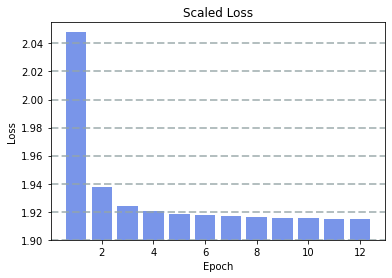

In [ ]:
# Plot the loss with some scaling
plt.bar([i for i in range(1,13)], 
        [(loss / len(TrAd.data)) for loss in model_tripAdvisor.losses],
        color='royalblue', 
        alpha=0.7)

plt.grid(color='#95a5a6',
         linestyle='--',
         linewidth=2,
         axis='y',
         alpha=0.7)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(1.9, 2.055)
plt.title('Scaled Loss')
plt.show()

# In the following, the code regarding the CBOW model from the SciFi data can be found.

In [ ]:
#supervise google collab gpu on external website
wandb.init()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
#Train the model on GPU
CONTEXT_SIZE = 2  # 2 words to the left, 2 to the right
EMBEDDING_DIM = 50 #this was proposed in the excercise sheet.
VOCAB_SIZE = len(ScFi.word_to_ix)
EPOCHS = 12
DATALOADER = dataloader_SciFi
model_SciFi = ModelTrainer(VOCAB_SIZE, EMBEDDING_DIM, EPOCHS, DATALOADER)

Training has started...
Completed epoch: 0, with loss: 1798045.486424446
Completed epoch: 1, with loss: 1685143.827660799
Completed epoch: 2, with loss: 1663289.2744021416
Completed epoch: 3, with loss: 1652981.5474276543
Completed epoch: 4, with loss: 1647370.9525547028
Completed epoch: 5, with loss: 1644098.571789503
Completed epoch: 6, with loss: 1642055.2729730606
Completed epoch: 7, with loss: 1640451.0267271996
Completed epoch: 8, with loss: 1639507.6277196407
Completed epoch: 9, with loss: 1638707.479288578
Completed epoch: 10, with loss: 1638217.0442771912
Completed epoch: 11, with loss: 1637565.5002009869


In [ ]:
#save the model to google drive (Note: save is only temporary (until kernel shuts down) i.e. DOWNLOAD!)
torch.save(model_SciFi.model, "scifi_model.pt")

In [ ]:
# total loss per epoch (devide by number of observations to get loss per observation)
model_SciFi.losses

[1798045.486424446,
 1685143.827660799,
 1663289.2744021416,
 1652981.5474276543,
 1647370.9525547028,
 1644098.571789503,
 1642055.2729730606,
 1640451.0267271996,
 1639507.6277196407,
 1638707.479288578,
 1638217.0442771912,
 1637565.5002009869]

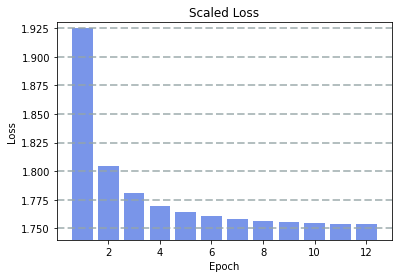

In [ ]:
# Plot the loss with some scaling
plt.bar([i for i in range(1,13)], 
        [(loss / len(ScFi.data)) for loss in model_SciFi.losses],
        color='royalblue', 
        alpha=0.7)

plt.grid(color='#95a5a6',
         linestyle='--',
         linewidth=2,
         axis='y',
         alpha=0.7)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(1.74, 1.93)
plt.title('Scaled Loss')
plt.show()

#Model Evaluation

#Model Evaluation

# 1. Evaluation of the TripAdvisor embeddings

In [ ]:
# Import statments
import torch.nn as nn
from collections import Counter
from itertools import product

# Load the trained model
model_tripAdvisor = torch.load('tripadvisor_model.pt', map_location='cpu')

# Choose 3 nouns, 3 verbs, and 3 adjectives (some should occur frequently while others should be rare.)
df_tr = pd.DataFrame.from_dict(trAd.data_X)

# Find the most common and least common words (manually inspect to split into adjectives, verbs and nouns.)
most_common = Counter(" ".join(df_tr['Review']).split()).most_common(100)
least_common = Counter(" ".join(df_tr['Review']).split()).most_common()[:-100:-1] 

print(most_common)
print(least_common)

# hotel (49886), room (35367), muggings (1)
nouns = ['hotel', 'room', 'muggings']

# stayed (10502), did (14008), victimized (1)
verbs = ['stayed', 'did', 'victimized']

# good (17424), great (21484), elusive (1)
adjectives = ['good', 'great', 'elusive']

words_tr = nouns + verbs + adjectives
word_to_index_tr = TrAd.word_to_ix
index_to_word_tr = dict([(value, key) for key, value in word_to_index_tr.items()])

#For each of the 9 chosen words, retrieve the 5 closest words according to our model.
def get_closest_word_hotel(word, topn=5):
  word_distance = []
  emb = model_tripAdvisor.embeddings
  pdist = nn.PairwiseDistance()
  i = word_to_index_tr[word]
  lookup_tensor_i = torch.tensor([i], dtype=torch.long)
  v_i = emb(lookup_tensor_i)
  for j in range(len(TrAd.word_to_ix)):
    if j != i:
      lookup_tensor_j = torch.tensor([j], dtype=torch.long)
      v_j = emb(lookup_tensor_j)
      word_distance.append((index_to_word_tr[j], float(pdist(v_i, v_j))))
  word_distance.sort(key=lambda x: x[1])
  return word_distance[:topn]

# Print the results
overview_tr = {}
for word in words_tr:
  close_words = get_closest_word_hotel(word)
  overview_tr[word] = close_words
s_tr  = pd.Series(overview_tr,index=overview_tr.keys())
for row in s_tr:
  print(row)


[('hotel', 49886), ('room', 35367), ('not', 31712), ('great', 21484), ('t', 19552), ('n', 19103), ('good', 17424), ('staff', 16641), ('stay', 15415), ('did', 14008), ('just', 12669), ('nice', 12647), ('rooms', 12412), ('no', 11853), ('location', 11359), ('stayed', 10502), ('service', 10377), ('night', 10170), ('time', 10134), ('beach', 10072), ('day', 9988), ('breakfast', 9738), ('clean', 9599), ('food', 9428), ('like', 8254), ('resort', 8154), ('place', 7792), ('really', 7790), ('the', 7615), ('pool', 7584), ('friendly', 6894), ('people', 6843), ('small', 6597), ('little', 6261), ('walk', 6256), ('got', 6206), ('excellent', 6193), ('area', 6121), ('best', 5750), ('helpful', 5708), ('bar', 5582), ('restaurant', 5341), ('restaurants', 5144), ('bathroom', 5107), ('water', 5039), ('trip', 5027), ('bed', 5002), ('recommend', 4865), ('view', 4737), ('beautiful', 4735), ('floor', 4696), ('went', 4680), ('comfortable', 4558), ('desk', 4476), ('nights', 4407), ('check', 4328), ('right', 4292),

# 2. Evaluation of the Sci-Fi model

In [ ]:
# Load the trained model
model_sciFi = torch.load('scifi_model.pt', map_location='cpu')

# Choose 3 nouns, 3 verbs, and 3 adjectives (some should occur frequently while others should be rare.)
df_sc = pd.DataFrame.from_dict(scFi.data_X)

# Find the most common and least common words (manually inspect to split into adjectives, verbs and nouns.)
most_common = Counter(" ".join(df_sc['Text']).split()).most_common(100)
least_common = Counter(" ".join(df_sc['Text']).split()).most_common()[:-100:-1] 

print(most_common)
print(least_common)


nouns_sc = ['time', 'jokers', 'coldbloodedness']
verbs_sc = ['had', 'was', 'shuffle']
adjectives_sc = ['first', 'marbled', 'up']

words_sc = nouns_sc + verbs_sc + adjectives_sc
word_to_index_sc = ScFi.word_to_ix
index_to_word_sc = dict([(value, key) for key, value in word_to_index_sc.items()])

#For each of the 9 chosen words, retrieve the 5 closest words according to our model.
def get_closest_word_scifi(word, topn=5):
  word_distance = []
  emb = model_sciFi.embeddings
  pdist = nn.PairwiseDistance()
  i = word_to_index_sc[word]
  lookup_tensor_i = torch.tensor([i], dtype=torch.long)
  v_i = emb(lookup_tensor_i)
  for j in range(len(ScFi.word_to_ix)):
    if j != i:
      lookup_tensor_j = torch.tensor([j], dtype=torch.long)
      v_j = emb(lookup_tensor_j)
      word_distance.append((index_to_word_sc[j], float(pdist(v_i, v_j))))
  word_distance.sort(key=lambda x: x[1])
  return word_distance[:topn]

overview_sc = {}
for word in words_sc:
  close_words = get_closest_word_scifi(word)
  overview_sc[word] = close_words
s_sc  = pd.Series(overview_sc,index=overview_sc.keys())
for row in s_sc:
  print(row)


[('the', 71950), ('and', 32065), ('of', 30805), ('to', 29662), ('a', 29636), ('he', 20246), ('i', 19301), ('it', 18227), ('in', 17059), ('was', 16193), ('you', 14728), ('that', 14493), ('his', 11322), ('s', 10028), ('had', 9309), ('t', 8973), ('for', 8780), ('on', 8432), ('but', 7971), ('with', 7911), ('as', 7568), ('they', 7033), ('at', 7011), ('be', 6587), ('is', 6484), ('we', 6356), ('said', 6151), ('not', 5784), ('have', 5575), ('him', 5300), ('there', 5218), ('from', 5041), ('all', 4989), ('this', 4857), ('were', 4749), ('she', 4726), ('one', 4666), ('out', 4629), ('what', 4486), ('if', 4369), ('her', 4298), ('no', 4100), ('up', 4065), ('by', 3963), ('me', 3815), ('would', 3789), ('an', 3787), ('them', 3578), ('could', 3462), ('been', 3433), ('my', 3377), ('or', 3358), ('so', 3305), ('are', 3194), ('can', 3147), ('into', 3084), ('then', 3058), ('like', 2999), ('about', 2948), ('do', 2872), ('your', 2805), ('when', 2779), ('now', 2743), ('back', 2687), ('time', 2674), ('man', 2473)

In [ ]:
# Choose 2 words and retrieve their 5 closest neighbours according to both embeddings
words = ['the', 'good']

# According to hotel review-based embeddings
overview_hotel = {}
for word in words:
  close_words = get_closest_word_hotel(word, topn=5)
  overview_hotel[word] = close_words

res_ht  = pd.Series(overview_hotel,index=overview_hotel.keys())
print('hotel model predictions:')
for row in res_ht:
  print(row)
print('\n')

# According to sci-fi review-based embeddings
overview_scifi = {}
for word in words:
  close_words = get_closest_word_scifi(word, topn=5)
  overview_scifi[word] = close_words

res_sc  = pd.Series(overview_scifi,index=overview_scifi.keys())
print('scifi model predictions:')
for row in res_sc:
  print(row)

hotel model predictions:
[('isn', 6.793273448944092), ('fullerton', 6.8118205070495605), ('dealt', 6.854813575744629), ('seaona', 6.896491527557373), ('repairing', 6.975038528442383)]
[('vaugirard', 6.875255107879639), ('greenbrier', 7.0506415367126465), ('auditorium', 7.262965202331543), ('tougher', 7.316408157348633), ('chronic', 7.319569110870361)]


scifi model predictions:
[('centaurean', 7.020124435424805), ('approvingly', 7.022852897644043), ('stupor', 7.143141746520996), ('trading', 7.2732439041137695), ('translating', 7.300394535064697)]
[('stella', 5.507462024688721), ('encyclopedias', 5.593226909637451), ('earnestly', 5.618689060211182), ('baen', 5.844242095947266), ('giller', 6.0032243728637695)]
